In [1]:
# CELL 1
import os, random, json, copy
from collections import OrderedDict, defaultdict
import numpy as np
import torch, torch.nn as nn
import torchvision.transforms as T
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
from sklearn.metrics import precision_score, recall_score, f1_score

# Globals (same as your original)
SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_CLIENTS = 6
ALPHA_LIST = [0.3, 0.15, 0.08]
all_alpha_logs = {}
ROUNDS = 30
LOCAL_EPOCHS = 2
BATCH_SIZE = 16
IMAGE_SIZE = 224
ROOT = "/kaggle/input/brain-tumor-mri-scans"  

DELAY_PROB = 0.15
FEDBUFF_APPLY_MULT = 0.6
Q_VAL = 0.2

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

os.makedirs("/kaggle/working/logs", exist_ok=True)
print("Device:", DEVICE)


Device: cuda


In [2]:
# CELL 2
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {c:i for i,c in enumerate(self.classes)}
        self.samples = []
        for c in self.classes:
            folder = os.path.join(root_dir, c)
            for f in sorted(os.listdir(folder)):
                if f.lower().endswith(("png","jpg","jpeg","tif","tiff")):
                    self.samples.append((os.path.join(folder, f), self.class_to_idx[c]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, lbl = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, lbl

transform_train = T.Compose([
    T.RandomResizedCrop(IMAGE_SIZE),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
transform_eval = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# quick instantiate to validate path (no transforms)
full_dataset = BrainTumorDataset(ROOT, transform=None)
print("Found classes:", full_dataset.classes)
print("Total images:", len(full_dataset))


Found classes: ['glioma', 'healthy', 'meningioma', 'pituitary']
Total images: 7023


In [3]:
# CELL 3
num_total = len(full_dataset)
indices = np.arange(num_total)
np.random.seed(SEED)
np.random.shuffle(indices)

train_frac = 0.80
val_frac = 0.10
n_train = int(train_frac * num_total)
n_val = int(val_frac * num_total)

train_idx = indices[:n_train]
val_idx = indices[n_train:n_train + n_val]
test_idx = indices[n_train + n_val:]

central_val_loader = DataLoader(Subset(BrainTumorDataset(ROOT, transform=transform_eval), val_idx),
                                batch_size=BATCH_SIZE, shuffle=False)
central_test_loader = DataLoader(Subset(BrainTumorDataset(ROOT, transform=transform_eval), test_idx),
                                 batch_size=BATCH_SIZE, shuffle=False)

print(f"Split sizes -> train: {len(train_idx)}, val: {len(val_idx)}, test: {len(test_idx)}")


Split sizes -> train: 5618, val: 702, test: 703


In [4]:
# CELL 4
def create_dirichlet_split_from_indices(dataset, indices_pool, num_clients, alpha, min_size=30):
    idx_by_class = defaultdict(list)
    for idx in indices_pool:
        _, y = dataset.samples[idx]
        idx_by_class[y].append(idx)

    client_map = {i: [] for i in range(num_clients)}

    for cls, idxs in idx_by_class.items():
        idxs = idxs.copy()
        np.random.shuffle(idxs)
        props = np.random.dirichlet([alpha] * num_clients)
        props = props / props.sum()
        counts = (props * len(idxs)).astype(int)
        counts[-1] = len(idxs) - counts[:-1].sum()
        ptr = 0
        for i in range(num_clients):
            client_map[i].extend(idxs[ptr:ptr+counts[i]])
            ptr += counts[i]

    # ensure min samples
    small = [c for c in client_map if len(client_map[c]) < min_size]
    big = [c for c in client_map if len(client_map[c]) >= min_size]

    leftover = []
    for c in small:
        leftover.extend(client_map[c])
        client_map[c] = []

    if leftover and len(big) > 0:
        np.random.shuffle(leftover)
        share = len(leftover) // len(big)
        for i, c in enumerate(big):
            s = i * share
            e = s + share if i < len(big)-1 else len(leftover)
            client_map[c].extend(leftover[s:e])

    return client_map

for DIRICHLET_ALPHA in ALPHA_LIST:

    print(f"\nCreating Dirichlet split for alpha = {DIRICHLET_ALPHA}")

    # Create new split for this alpha
    client_map = create_dirichlet_split_from_indices(
        full_dataset,
        train_idx,
        NUM_CLIENTS,
        DIRICHLET_ALPHA,
        min_size=30
    )

    print("Per-client counts:")
    for k in client_map:
        print(k, len(client_map[k]))

    # Save client map per alpha
    safe_map = {str(k): [int(x) for x in v] for k, v in client_map.items()}
    with open(f'/kaggle/working/logs/client_map_alpha_{DIRICHLET_ALPHA}.json', 'w') as f:
        json.dump(safe_map, f)

    # --------------------------
    # Build Client Loaders
    # --------------------------
    client_loaders = {}

    for cid, idxs in client_map.items():
        idxs_sh = idxs.copy()
        np.random.seed(SEED + cid)
        np.random.shuffle(idxs_sh)

        if len(idxs_sh) < 2:
            tr_idx = idxs_sh
            vl_idx = idxs_sh
        else:
            n_local_train = max(1, int(0.85 * len(idxs_sh)))
            tr_idx = idxs_sh[:n_local_train]
            vl_idx = idxs_sh[n_local_train:]

    if len(vl_idx) == 0:
        vl_idx = tr_idx[:1]
        client_loaders[cid] = {
            "train": DataLoader(
                Subset(BrainTumorDataset(ROOT, transform=transform_train), tr_idx),
                batch_size=BATCH_SIZE,
                shuffle=True,
                generator=torch.Generator().manual_seed(SEED + cid)
            ),
            "val": DataLoader(
                Subset(BrainTumorDataset(ROOT, transform=transform_eval), vl_idx),
                batch_size=BATCH_SIZE,
                shuffle=False
            )
        }

    print("Built client loaders.")



Creating Dirichlet split for alpha = 0.3
Per-client counts:
0 1104
1 170
2 1060
3 265
4 1733
5 1286
Built client loaders.

Creating Dirichlet split for alpha = 0.15
Per-client counts:
0 1790
1 1306
2 503
3 685
4 584
5 750
Built client loaders.

Creating Dirichlet split for alpha = 0.08
Per-client counts:
0 2334
1 0
2 1510
3 100
4 214
5 1460
Built client loaders.


In [5]:
# CELL 6
class SimpleEffNet(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.backbone = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        in_f = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_f, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )
        n_freeze = int(0.7 * len(list(self.backbone.features.parameters())))
        for i, p in enumerate(self.backbone.features.parameters()):
            if i < n_freeze:
                p.requires_grad = False

    def forward(self, x):
        return self.backbone(x)

def local_train(global_model, loader, epochs, use_fedprox=False, mu=0.08, lr=1e-3):
    if len(loader.dataset) == 0:
        return copy.deepcopy(global_model), 0.0

    model = copy.deepcopy(global_model).to(DEVICE)
    model.train()
    opt = torch.optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=lr, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=max(1, epochs))
    loss_fn = nn.CrossEntropyLoss()
    g_params = [p.detach().clone() for p in global_model.parameters()]

    losses = []
    for ep in range(epochs):
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            out = model(xb)
            loss = loss_fn(out, yb)
            if use_fedprox:
                prox = 0.0
                for lp, gp in zip(model.parameters(), g_params):
                    prox = prox + torch.norm(lp - gp.to(lp.device))**2
                loss = loss + (mu / 2.0) * prox
            loss.backward()
            torch.nn.utils.clip_grad_norm_([p for p in model.parameters() if p.requires_grad], 1.0)
            opt.step()
            losses.append(float(loss.detach().cpu().numpy()))
        scheduler.step()

    avg_loss = float(np.mean(losses)) if losses else 0.0
    return model, avg_loss

def fedavg_aggregate(global_model, client_models, weights=None):
    g_state = global_model.state_dict()
    new_state = OrderedDict()
    if weights is None:
        weights = [1.0/len(client_models)] * len(client_models)
    for k in g_state:
        if g_state[k].dtype == torch.int64:
            new_state[k] = g_state[k].clone()
            continue
        accum = None
        for i, cm in enumerate(client_models):
            val = cm.state_dict()[k].float().to(g_state[k].device)
            w = weights[i]
            accum = val * w if accum is None else accum + val * w
        new_state[k] = accum.type_as(g_state[k])
    return new_state

class FedBuff:
    def __init__(self):
        self.buffer = []
    def add(self, state, samples, rnd):
        self.buffer.append({"state": {k:v.clone().cpu() for k,v in state.items()}, "samples": samples, "round": rnd})
    def apply(self, current_state, cur_round, apply_prob=0.4, max_age=8, apply_mult=FEDBUFF_APPLY_MULT):
        new_state = OrderedDict((k, v.clone()) for k,v in current_state.items())
        self.buffer = [b for b in self.buffer if (cur_round - b["round"]) <= max_age]
        apply_indices = [i for i in range(len(self.buffer)) if random.random() < apply_prob]
        for idx in sorted(apply_indices, reverse=True):
            b = self.buffer[idx]
            for k in new_state:
                if new_state[k].dtype != torch.int64:
                    delta = b["state"][k].to(new_state[k].device) - new_state[k]
                    new_state[k] = new_state[k] + apply_mult * delta
            del self.buffer[idx]
        return new_state

def compute_q_weights(losses, samples, q=Q_VAL, eps=1e-8):
    w = []
    for i in range(len(samples)):
        L = max(losses[i], eps)
        w.append(samples[i] * ((L + eps) ** q))
    s = sum(w)
    if s <= 0:
        return [s_i / sum(samples) for s_i in samples]
    return [wi / s for wi in w]

def evaluate(model, loader):
    if len(loader.dataset) == 0:
        return 0,0,0,0
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            p = model(xb).argmax(1)
            preds.extend(p.cpu().numpy().tolist())
            labels.extend(yb.cpu().numpy().tolist())
    preds = np.array(preds); labels = np.array(labels)
    acc = 100 * np.mean(preds == labels)
    prec = precision_score(labels, preds, average="macro", zero_division=0)
    rec = recall_score(labels, preds, average="macro", zero_division=0)
    f1 = f1_score(labels, preds, average="macro", zero_division=0)
    return acc, prec, rec, f1

def print_summary(r, stats):
    print(f"""
================ ROUND {r} ================
Acc        : {stats['acc']:.2f}%
Precision  : {stats['prec']:.3f}
Recall     : {stats['rec']:.3f}
F1 Score   : {stats['f1']:.3f}
Fairness   : {stats['fairness']:.3f}
Avg Stale  : {stats['avg_stale']:.3f}
ClientLoss : {[round(x, 3) for x in stats['losses']]}
Active     : {stats['active']}
Delayed    : {stats['delayed']}
===========================================
""")


In [6]:
import copy
import random
import numpy as np
import torch
from torch.utils.data import DataLoader, Subset
import json

print("Running FL with QFedAvg + FedBuff + FedProx + Lazy + Availability + StoreForward (No Defenses)")

# ==========================================
# Hyperparameters
# ==========================================
ALPHA_LIST = [0.3, 0.15, 0.08]
LAZY_PROB = 0.15
MIN_ACTIVE = 3
FEDPROX_MU = 0.01
APPLY_PROB = 0.2
MAX_AGE = 3
LOCAL_EPOCHS = 1
NUM_CLASSES = len(full_dataset.classes)
BATCH_SIZE = 32
ROUNDS = 30
Q_VAL = 0.2

all_alpha_logs = {}

# ==========================================
# QFedAvg weights computation
# ==========================================
def compute_q_weights(losses, samples, q=0.2):
    weights = [(s * ((l + 1e-10) ** q)) for l, s in zip(losses, samples)]
    total = sum(weights)
    return [w / total for w in weights]

# ==========================================
# QFedAvg aggregation
# ==========================================
def qfedavg_aggregate(global_model, client_models, weights):
    new_state = copy.deepcopy(global_model.state_dict())
    for key in new_state:
        if not torch.is_floating_point(new_state[key]):
            continue
        weighted_sum = sum(w * cm.state_dict()[key].float() for w, cm in zip(weights, client_models))
        new_state[key] = weighted_sum
    return new_state

# ==========================================
# Main loop over alphas
# ==========================================
for DIRICHLET_ALPHA in ALPHA_LIST:

    print("\n====================================")
    print("DIRICHLET_ALPHA =", DIRICHLET_ALPHA)
    print("====================================")

    # Create Dirichlet split
    client_map = create_dirichlet_split_from_indices(
        full_dataset,
        train_idx,
        NUM_CLIENTS,
        DIRICHLET_ALPHA,
        min_size=30
    )
    client_map = {cid: idxs for cid, idxs in client_map.items() if len(idxs) > 0}

    # Build client loaders
    client_loaders = {}
    for cid, idxs in client_map.items():
        idxs_sh = idxs.copy()
        np.random.shuffle(idxs_sh)
        n_local_train = max(1, int(0.85 * len(idxs_sh)))
        tr_idx = idxs_sh[:n_local_train]
        vl_idx = idxs_sh[n_local_train:]
        if len(vl_idx) == 0:
            vl_idx = tr_idx[:1]
        client_loaders[cid] = {
            "train": DataLoader(
                Subset(BrainTumorDataset(ROOT, transform=transform_train), tr_idx),
                batch_size=BATCH_SIZE,
                shuffle=True
            ),
            "val": DataLoader(
                Subset(BrainTumorDataset(ROOT, transform=transform_eval), vl_idx),
                batch_size=BATCH_SIZE,
                shuffle=False
            )
        }

    # Initialize buffers and staleness
    sf_buffer = {cid: [] for cid in client_loaders}
    staleness = {cid: 0 for cid in client_loaders}

    # Initialize global model and FedBuff
    model = SimpleEffNet(num_classes=NUM_CLASSES).to(DEVICE)
    buffer = FedBuff()
    log_data = []

    # TRAINING LOOP
    for r in range(ROUNDS):

        active, delayed, lazy_clients = [], [], []

        # Dynamic availability selection
        availability = np.random.beta(DIRICHLET_ALPHA, DIRICHLET_ALPHA, len(client_loaders))
        for i, cid in enumerate(client_loaders):
            if random.random() < availability[i]:
                active.append(cid)
                staleness[cid] = 0
            else:
                delayed.append(cid)
                staleness[cid] += 1

        # Guarantee minimum active clients
        if len(active) < MIN_ACTIVE:
            pool = list(set(client_loaders.keys()) - set(active))
            needed = min(MIN_ACTIVE - len(active), len(pool))
            active += random.sample(pool, needed)
            delayed = [c for c in client_loaders if c not in active]

        client_models, client_losses, client_samples = [], [], []

        # ----------------------
        # ACTIVE CLIENTS TRAINING
        # ----------------------
        for cid in active:

            # Flush StoreForward buffer
            if len(sf_buffer[cid]) > 0:
                for upd in sf_buffer[cid]:
                    buffer.add(upd, len(client_loaders[cid]["train"].dataset), r)
                sf_buffer[cid] = []

            # Lazy client simulation
            if random.random() < LAZY_PROB:
                lazy_clients.append(cid)
                lm = SimpleEffNet(num_classes=NUM_CLASSES).to(DEVICE)
                lm.load_state_dict(model.state_dict())  # just copy global model
                loss = 0.05
            else:
                lm, loss = local_train(
                    model,
                    client_loaders[cid]["train"],
                    LOCAL_EPOCHS,
                    use_fedprox=True,
                    mu=FEDPROX_MU
                )

            client_models.append(lm)
            client_losses.append(loss)
            client_samples.append(len(client_loaders[cid]["train"].dataset))

        # -----------------------------
        # QFedAvg aggregation (no defenses)
        # -----------------------------
        if len(client_models) > 0:
            q_weights = compute_q_weights(client_losses, client_samples, q=Q_VAL)
            qfed_state = qfedavg_aggregate(model, client_models, q_weights)
            model.load_state_dict(qfed_state)

        # Apply FedBuff
        model.load_state_dict(buffer.apply(model.state_dict(), r, APPLY_PROB, MAX_AGE, 0.5))

        # ----------------------
        # Evaluation
        # ----------------------
        gacc, prec, rec, f1 = evaluate(model, central_val_loader)
        accs = [evaluate(model, client_loaders[c]["val"])[0] for c in client_loaders]
        fairness = float(np.std(accs))
        avg_stale = float(np.mean(list(staleness.values())))

        stats = {
            "round": r,
            "acc": gacc,
            "prec": prec,
            "rec": rec,
            "f1": f1,
            "fairness": fairness,
            "avg_stale": avg_stale,
            "active": active,
            "delayed": delayed,
            "lazy_clients": lazy_clients,
            "losses": client_losses
        }

        print_summary(r, stats)
        log_data.append(stats)

    # --------------------------
    # Save final model and logs
    # --------------------------
    with open(f"/kaggle/working/logs/ATK_ONLY_FL_ALPHA_{DIRICHLET_ALPHA}.json", "w") as f:
        json.dump(log_data, f, indent=2)

    torch.save(
        model.state_dict(),
        f"/kaggle/working/logs/ATK_ONLY_FL_ALPHA_{DIRICHLET_ALPHA}_final.pth"
    )

    all_alpha_logs[DIRICHLET_ALPHA] = log_data

print("ALL FL EXPERIMENTS WITH ATTACK ONLY COMPLETED")

Running FL with QFedAvg + FedBuff + FedProx + Lazy + Availability + StoreForward (No Defenses)

DIRICHLET_ALPHA = 0.3


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 149MB/s]



================ ROUND 0 ================
Acc        : 31.91%
Precision  : 0.080
Recall     : 0.250
F1 Score   : 0.121
Fairness   : 35.202
Avg Stale  : 0.667
ClientLoss : [0.42, 0.05, 0.05]
Active     : [1, 5, 0]
Delayed    : [2, 3, 4]


================ ROUND 1 ================
Acc        : 65.67%
Precision  : 0.731
Recall     : 0.647
F1 Score   : 0.592
Fairness   : 24.180
Avg Stale  : 1.000
ClientLoss : [0.234, 1.793, 0.872]
Active     : [1, 2, 5]
Delayed    : [0, 3, 4]


================ ROUND 2 ================
Acc        : 72.79%
Precision  : 0.815
Recall     : 0.686
F1 Score   : 0.620
Fairness   : 14.970
Avg Stale  : 0.833
ClientLoss : [0.05, 0.981, 1.082]
Active     : [1, 3, 4]
Delayed    : [0, 2, 5]


================ ROUND 3 ================
Acc        : 84.76%
Precision  : 0.860
Recall     : 0.836
F1 Score   : 0.838
Fairness   : 6.734
Avg Stale  : 0.667
ClientLoss : [0.05, 1.671, 0.566]
Active     : [0, 2, 4]
Delayed    : [1, 3, 5]


================ ROUND 4 ================

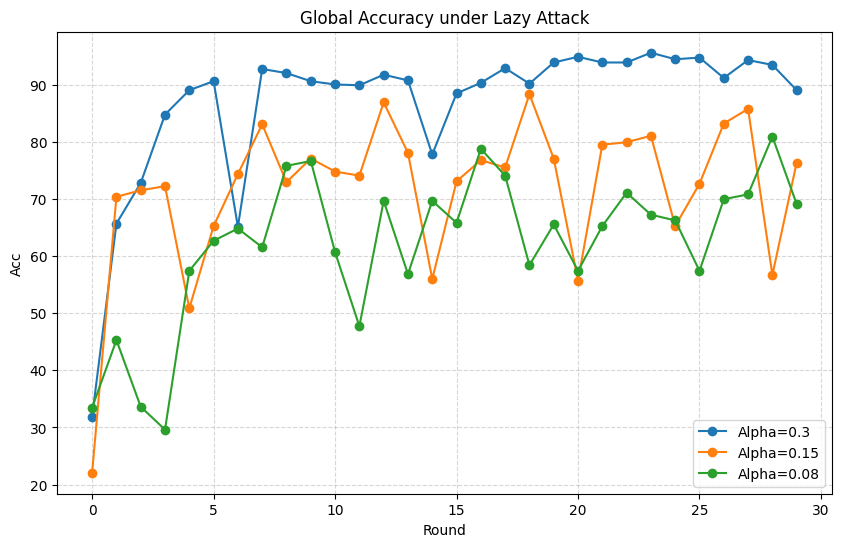

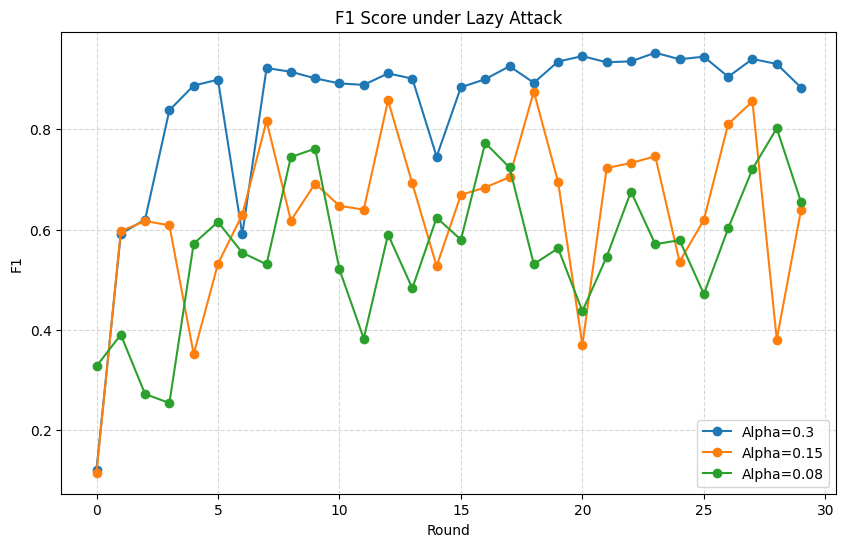

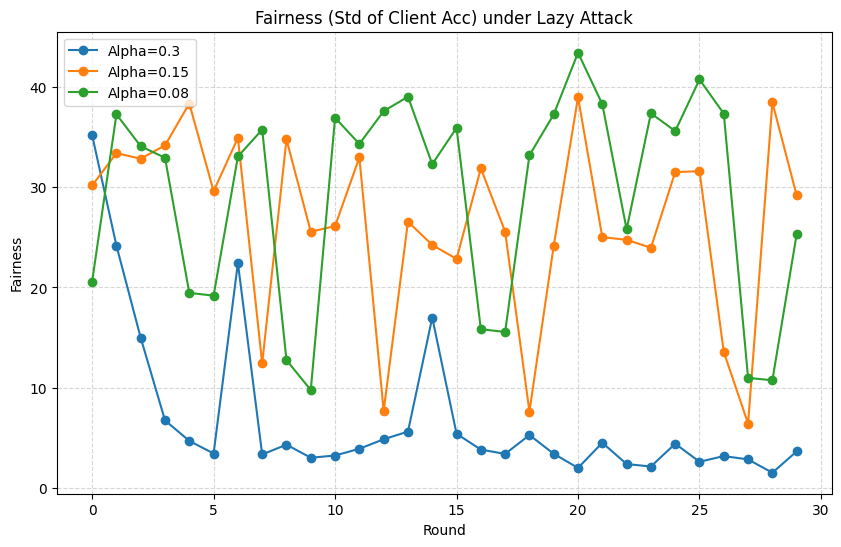

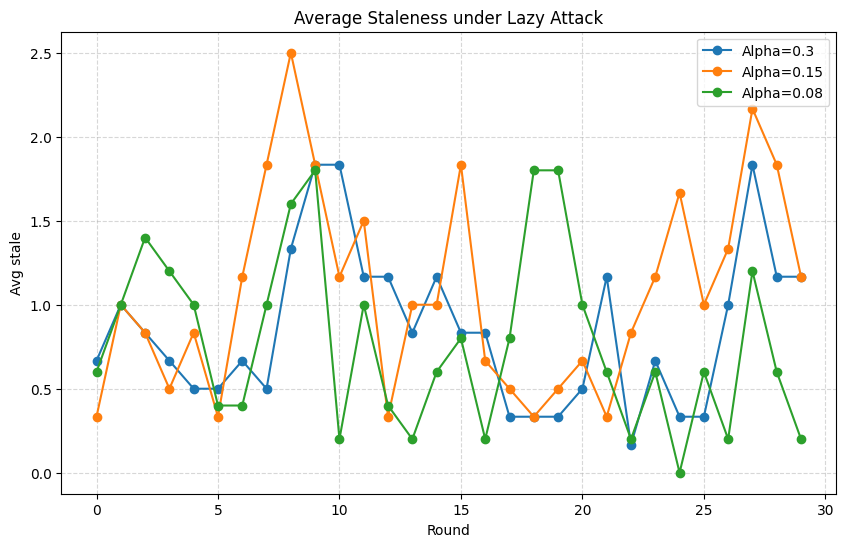

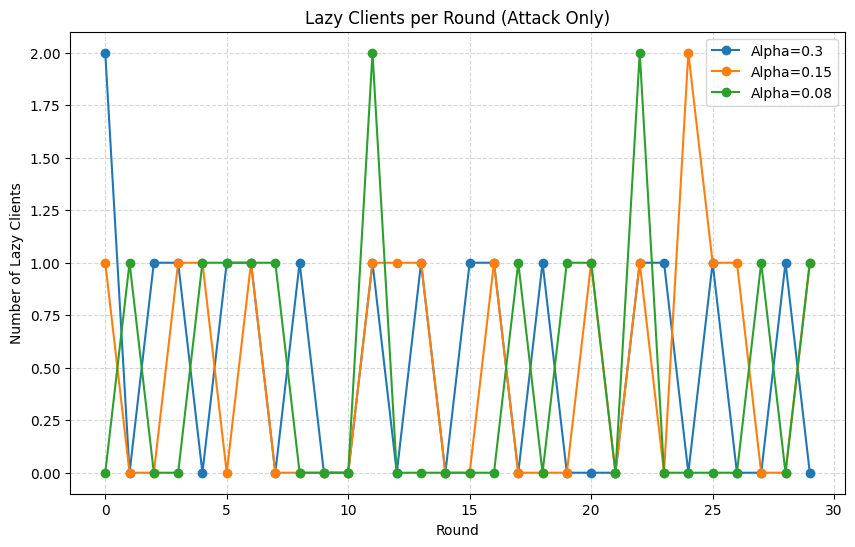

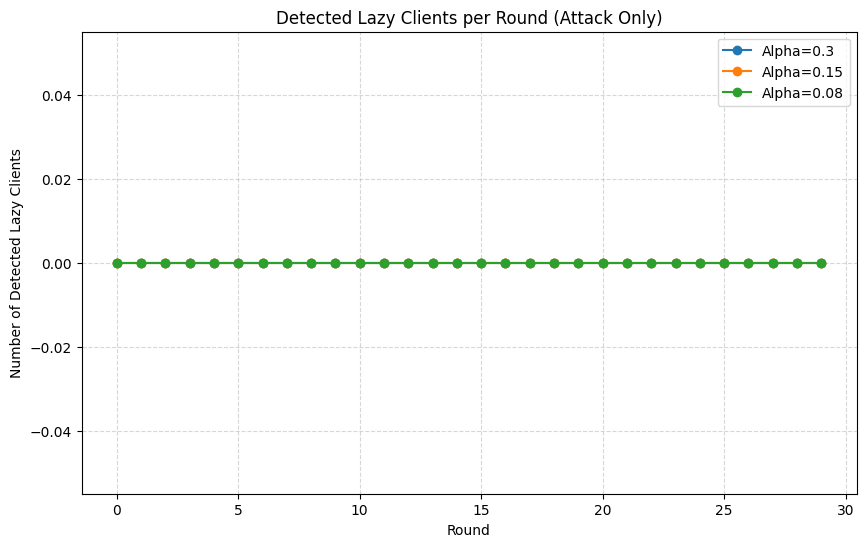

In [9]:
import matplotlib.pyplot as plt

# -----------------------------------------
# General plot function
# -----------------------------------------
def plot_fl_results(logs, metric='acc', title=None):
    plt.figure(figsize=(10,6))
    
    for alpha, log_data in logs.items():
        values = [round_stats[metric] for round_stats in log_data]
        plt.plot(range(len(values)), values, marker='o', label=f'Alpha={alpha}')
    
    plt.xlabel('Round')
    plt.ylabel(metric.replace('_', ' ').capitalize())
    if title:
        plt.title(title)
    else:
        plt.title(f'FL {metric.replace("_", " ").capitalize()} over Rounds')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.show()

# -----------------------------------------
# Plot Global Accuracy
# -----------------------------------------
plot_fl_results(all_alpha_logs, metric='acc', title='Global Accuracy under Lazy Attack')

# -----------------------------------------
# Plot F1 Score
# -----------------------------------------
plot_fl_results(all_alpha_logs, metric='f1', title='F1 Score under Lazy Attack')

# -----------------------------------------
# Plot Fairness (std of client accuracies)
# -----------------------------------------
plot_fl_results(all_alpha_logs, metric='fairness', title='Fairness (Std of Client Acc) under Lazy Attack')

# -----------------------------------------
# Plot Average Staleness
# -----------------------------------------
plot_fl_results(all_alpha_logs, metric='avg_stale', title='Average Staleness under Lazy Attack')

# -----------------------------------------
# Plot Number of Lazy Clients
# -----------------------------------------
plt.figure(figsize=(10,6))
for alpha, log_data in all_alpha_logs.items():
    lazy_counts = [len(round_stats['lazy_clients']) for round_stats in log_data]
    plt.plot(range(len(lazy_counts)), lazy_counts, marker='o', label=f'Alpha={alpha}')
plt.xlabel('Round')
plt.ylabel('Number of Lazy Clients')
plt.title('Lazy Clients per Round (Attack Only)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

# -----------------------------------------
# Plot Number of Detected Lazy Clients
# -----------------------------------------
plt.figure(figsize=(10,6))
for alpha, log_data in all_alpha_logs.items():
    # In attack-only mode, detected_lazy may be empty since we disabled defenses
    detected_lazy_counts = [len(round_stats.get('detected_lazy', [])) for round_stats in log_data]
    plt.plot(range(len(detected_lazy_counts)), detected_lazy_counts, marker='o', label=f'Alpha={alpha}')
plt.xlabel('Round')
plt.ylabel('Number of Detected Lazy Clients')
plt.title('Detected Lazy Clients per Round (Attack Only)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

In [11]:
print("Running FINAL QFedAvg + FedBuff + FedProx + Lazy + Defense + Availability + StoreForward")

# ==========================================
# Alpha values to test
# ==========================================
ALPHA_LIST = [0.3, 0.15, 0.08]

# ==========================================
# Stability & Accuracy Parameters
# ==========================================
LAZY_PROB = 0.15
MIN_ACTIVE = 3
FEDPROX_MU = 0.01
LAZY_NORM_THRESHOLD = 0.02
APPLY_PROB = 0.2
MAX_AGE = 3
Q_VAL = 0.2

NUM_CLASSES = len(full_dataset.classes)
all_alpha_logs = {}

# ==========================================
# Defense: update norm
# ==========================================
def model_update_norm(global_model, local_model):
    norm = 0.0
    g_state = global_model.state_dict()
    l_state = local_model.state_dict()

    for k in g_state:
        if not torch.is_floating_point(g_state[k]):
            continue
        diff = l_state[k] - g_state[k]
        norm += torch.norm(diff).item() ** 2

    return norm ** 0.5


# ==========================================
# LOOP OVER ALPHAS
# ==========================================
for DIRICHLET_ALPHA in ALPHA_LIST:

    print("\n====================================")
    print("DIRICHLET_ALPHA =", DIRICHLET_ALPHA)
    print("====================================")

    # ----------------------------------
    # Create Dirichlet split
    # ----------------------------------
    client_map = create_dirichlet_split_from_indices(
        full_dataset,
        train_idx,
        NUM_CLIENTS,
        DIRICHLET_ALPHA,
        min_size=30
    )

    # Remove empty clients (CRITICAL FIX)
    client_map = {
        cid: idxs for cid, idxs in client_map.items()
        if len(idxs) > 0
    }

    print("Client sizes:")
    for cid, idxs in client_map.items():
        print(f"Client {cid}: {len(idxs)} samples")

    # ----------------------------------
    # Build client loaders
    # ----------------------------------
    client_loaders = {}

    for cid, idxs in client_map.items():

        idxs_sh = idxs.copy()
        np.random.shuffle(idxs_sh)

        n_local_train = max(1, int(0.85 * len(idxs_sh)))
        tr_idx = idxs_sh[:n_local_train]
        vl_idx = idxs_sh[n_local_train:]

        if len(vl_idx) == 0:
            vl_idx = tr_idx[:1]

        client_loaders[cid] = {
            "train": DataLoader(
                Subset(BrainTumorDataset(ROOT, transform=transform_train), tr_idx),
                batch_size=BATCH_SIZE,
                shuffle=True
            ),
            "val": DataLoader(
                Subset(BrainTumorDataset(ROOT, transform=transform_eval), vl_idx),
                batch_size=BATCH_SIZE,
                shuffle=False
            )
        }

    # Availability simulation
    availability = np.random.beta(
        DIRICHLET_ALPHA,
        DIRICHLET_ALPHA,
        len(client_loaders)
    )

    sf_buffer = {cid: [] for cid in client_loaders}

    # ----------------------------------
    # Model setup
    # ----------------------------------
    model = SimpleEffNet(num_classes=NUM_CLASSES).to(DEVICE)
    buffer = FedBuff()
    log_data = []
    staleness = {cid: 0 for cid in client_loaders}

    # ==========================================
    # TRAINING LOOP
    # ==========================================
    for r in range(ROUNDS):

        active, delayed = [], []
        lazy_clients = []

        # Availability selection
        for i, cid in enumerate(client_loaders):
            if random.random() < availability[i]:
                active.append(cid)
                staleness[cid] = 0
            else:
                delayed.append(cid)
                staleness[cid] += 1

        # Guarantee minimum participation
        if len(active) < MIN_ACTIVE:
            remaining = list(set(client_loaders.keys()) - set(active))
            needed = min(MIN_ACTIVE - len(active), len(remaining))
            active += random.sample(remaining, needed)

        client_models = []
        client_losses = []
        client_samples = []

        # ----------------------
        # ACTIVE CLIENTS
        # ----------------------
        for cid in active:

            # Flush StoreForward buffer
            if len(sf_buffer[cid]) > 0:
                for upd in sf_buffer[cid]:
                    buffer.add(
                        upd,
                        len(client_loaders[cid]["train"].dataset),
                        r
                    )
                sf_buffer[cid] = []

            # Lazy client simulation
            if random.random() < LAZY_PROB:
                lazy_clients.append(cid)

                lazy_model = SimpleEffNet(num_classes=NUM_CLASSES).to(DEVICE)
                lazy_model.load_state_dict(model.state_dict())

                client_models.append(lazy_model)
                client_losses.append(0.05)
                client_samples.append(
                    len(client_loaders[cid]["train"].dataset)
                )
            else:
                lm, loss = local_train(
                    model,
                    client_loaders[cid]["train"],
                    LOCAL_EPOCHS,
                    use_fedprox=True,
                    mu=FEDPROX_MU
                )

                client_models.append(lm)
                client_losses.append(loss)
                client_samples.append(
                    len(client_loaders[cid]["train"].dataset)
                )

        # ----------------------
        # DEFENSE FILTER
        # ----------------------
        filtered_models = []
        filtered_losses = []
        filtered_samples = []
        detected_lazy = []

        for i, lm in enumerate(client_models):
            norm = model_update_norm(model, lm)

            if norm < LAZY_NORM_THRESHOLD:
                detected_lazy.append(active[i])
                continue

            filtered_models.append(lm)
            filtered_losses.append(client_losses[i])
            filtered_samples.append(client_samples[i])

        print("Detected lazy clients:", detected_lazy)

        # ----------------------
        # QFedAvg aggregation
        # ----------------------
        if len(filtered_models) > 0:
            q_weights = compute_q_weights(
                filtered_losses,
                filtered_samples,
                q=Q_VAL
            )

            model.load_state_dict(
                fedavg_aggregate(
                    model,
                    filtered_models,
                    q_weights
                )
            )

        # ----------------------
        # Apply FedBuff
        # ----------------------
        model.load_state_dict(
            buffer.apply(
                model.state_dict(),
                cur_round=r,
                apply_prob=APPLY_PROB,
                max_age=MAX_AGE,
                apply_mult=0.5
            )
        )

        # ----------------------
        # Evaluation
        # ----------------------
        gacc, prec, rec, f1 = evaluate(
            model,
            central_val_loader
        )

        accs = [
            evaluate(model, client_loaders[c]["val"])[0]
            for c in client_loaders
        ]

        fairness = float(np.std(accs))
        avg_stale = float(np.mean(list(staleness.values())))

        stats = {
            "round": r,
            "acc": gacc,
            "prec": prec,
            "rec": rec,
            "f1": f1,
            "fairness": fairness,
            "avg_stale": avg_stale,
            "active": active,
            "delayed": delayed,
            "lazy_clients": lazy_clients,
            "detected_lazy": detected_lazy,
            "losses": client_losses
        }

        print_summary(r, stats)
        log_data.append(stats)

    # ==========================================
    # SAVE RESULTS
    # ==========================================
    with open(
        f"/kaggle/working/logs/FINAL_FL_ALPHA_{DIRICHLET_ALPHA}.json",
        "w"
    ) as f:
        json.dump(log_data, f, indent=2)

    torch.save(
        model.state_dict(),
        f"/kaggle/working/logs/FINAL_FL_ALPHA_{DIRICHLET_ALPHA}_final.pth"
    )

    all_alpha_logs[DIRICHLET_ALPHA] = log_data

print("ALL EXPERIMENTS COMPLETED")

Running FINAL QFedAvg + FedBuff + FedProx + Lazy + Defense + Availability + StoreForward

DIRICHLET_ALPHA = 0.3
Client sizes:
Client 0: 1089 samples
Client 1: 625 samples
Client 2: 49 samples
Client 3: 1047 samples
Client 4: 326 samples
Client 5: 2482 samples


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 133MB/s] 


Detected lazy clients: [5, 0]

================ ROUND 0 ================
Acc        : 41.88%
Precision  : 0.286
Recall     : 0.352
F1 Score   : 0.268
Fairness   : 31.669
Avg Stale  : 0.667
ClientLoss : [0.345, 0.05, 0.05]
Active     : [1, 5, 0]
Delayed    : [0, 2, 3, 4]

Detected lazy clients: [3]

================ ROUND 1 ================
Acc        : 79.06%
Precision  : 0.832
Recall     : 0.784
F1 Score   : 0.773
Fairness   : 16.235
Avg Stale  : 1.500
ClientLoss : [0.971, 0.05, 4.413]
Active     : [5, 3, 2]
Delayed    : [0, 1, 2, 3, 4]

Detected lazy clients: []

================ ROUND 2 ================
Acc        : 88.60%
Precision  : 0.898
Recall     : 0.881
F1 Score   : 0.881
Fairness   : 9.114
Avg Stale  : 1.833
ClientLoss : [1.145, 0.674, 0.816]
Active     : [2, 5, 0]
Delayed    : [0, 1, 3, 4]

Detected lazy clients: [3]

================ ROUND 3 ================
Acc        : 91.17%
Precision  : 0.920
Recall     : 0.904
F1 Score   : 0.907
Fairness   : 4.034
Avg Stale  : 2.500
C

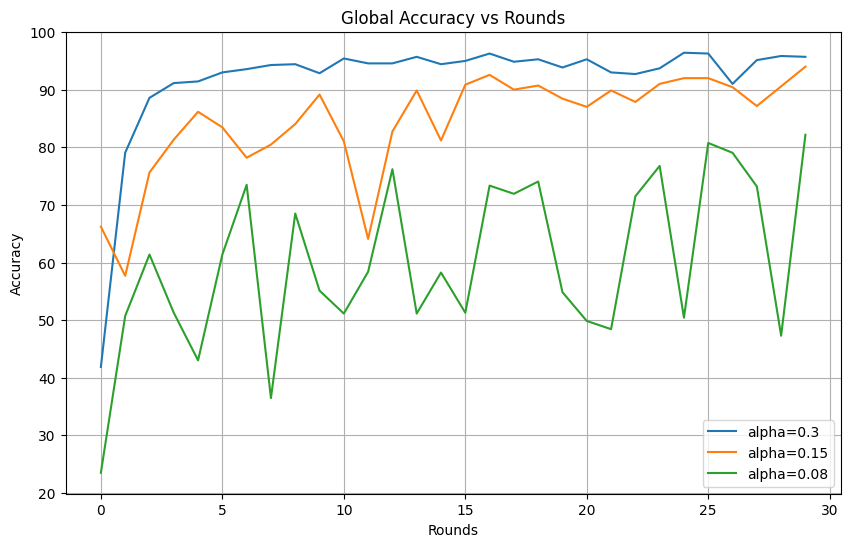

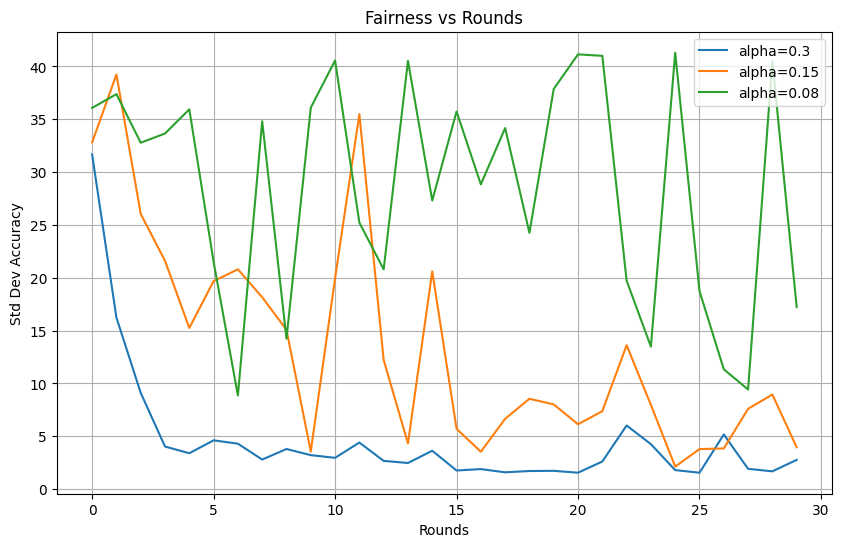

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

for alpha, logs in all_alpha_logs.items():
    rounds = [x["round"] for x in logs]
    acc = [x["acc"] for x in logs]
    plt.plot(rounds, acc, label=f"alpha={alpha}")

plt.title("Global Accuracy vs Rounds")
plt.xlabel("Rounds")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))

for alpha, logs in all_alpha_logs.items():
    rounds = [x["round"] for x in logs]
    fairness = [x["fairness"] for x in logs]
    plt.plot(rounds, fairness, label=f"alpha={alpha}")

plt.title("Fairness vs Rounds")
plt.xlabel("Rounds")
plt.ylabel("Std Dev Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
import copy
import random
import numpy as np
import torch
from torch.utils.data import DataLoader, Subset
import json

print("Running FINAL QFedAvg + FedBuff + FedProx + Lazy + TrimmedMean + Availability + StoreForward")

# ==========================================
# Hyperparameters
# ==========================================
ALPHA_LIST = [0.3, 0.15, 0.08]
LAZY_PROB = 0.15
MIN_ACTIVE = 3
FEDPROX_MU = 0.01
APPLY_PROB = 0.2
MAX_AGE = 3
TRIM_RATIO = 0.2
Q_VAL = 0.2

NUM_CLASSES = len(full_dataset.classes)
BATCH_SIZE = 32
ROUNDS = 30
LOCAL_EPOCHS = 1

all_alpha_logs = {}

# ==========================================
# Trimmed mean aggregation (defense)
# ==========================================
def trimmed_mean_aggregate(global_model, client_models, trim_ratio=0.2):
    new_state = copy.deepcopy(global_model.state_dict())
    client_states = [m.state_dict() for m in client_models]
    n_clients = len(client_states)
    trim_k = int(n_clients * trim_ratio)

    for key in new_state:
        if not torch.is_floating_point(new_state[key]):
            continue

        stacked = torch.stack([cs[key].float() for cs in client_states], dim=0)
        sorted_vals, _ = torch.sort(stacked, dim=0)

        if n_clients > 2 * trim_k:
            trimmed = sorted_vals[trim_k:n_clients - trim_k]
        else:
            trimmed = sorted_vals

        new_state[key] = torch.mean(trimmed, dim=0)

    return new_state

# ==========================================
# Model update norm (for lazy detection only)
# ==========================================
def model_update_norm(global_model, local_model):
    norm = 0.0
    g_state = global_model.state_dict()
    l_state = local_model.state_dict()
    for k in g_state:
        if not torch.is_floating_point(g_state[k]):
            continue
        diff = l_state[k] - g_state[k]
        norm += torch.norm(diff).item() ** 2
    return norm ** 0.5

# ==========================================
# Main loop over alphas
# ==========================================
for DIRICHLET_ALPHA in ALPHA_LIST:

    print("\n====================================")
    print("DIRICHLET_ALPHA =", DIRICHLET_ALPHA)
    print("====================================")

    # -------------------------
    # Create Dirichlet split
    # -------------------------
    client_map = create_dirichlet_split_from_indices(
        full_dataset,
        train_idx,
        NUM_CLIENTS,
        DIRICHLET_ALPHA,
        min_size=30
    )
    client_map = {cid: idxs for cid, idxs in client_map.items() if len(idxs) > 0}

    # -------------------------
    # Build client loaders
    # -------------------------
    client_loaders = {}
    for cid, idxs in client_map.items():
        idxs_sh = idxs.copy()
        np.random.shuffle(idxs_sh)
        n_local_train = max(1, int(0.85 * len(idxs_sh)))
        tr_idx = idxs_sh[:n_local_train]
        vl_idx = idxs_sh[n_local_train:]
        if len(vl_idx) == 0:
            vl_idx = tr_idx[:1]

        client_loaders[cid] = {
            "train": DataLoader(
                Subset(BrainTumorDataset(ROOT, transform=transform_train), tr_idx),
                batch_size=BATCH_SIZE,
                shuffle=True
            ),
            "val": DataLoader(
                Subset(BrainTumorDataset(ROOT, transform=transform_eval), vl_idx),
                batch_size=BATCH_SIZE,
                shuffle=False
            )
        }

    # -------------------------
    # Initialize Store & Forward buffer and staleness
    # -------------------------
    sf_buffer = {cid: [] for cid in client_loaders}
    staleness = {cid: 0 for cid in client_loaders}

    # -------------------------
    # Initialize model and FedBuff
    # -------------------------
    model = SimpleEffNet(num_classes=NUM_CLASSES).to(DEVICE)
    buffer = FedBuff()
    log_data = []

    # -----------------------------------------
    # TRAINING LOOP
    # -----------------------------------------
    for r in range(ROUNDS):

        # Dynamic availability
        availability = np.random.beta(DIRICHLET_ALPHA, DIRICHLET_ALPHA, len(client_loaders))

        active, delayed, lazy_clients = [], [], []

        # Select active and delayed clients
        for i, cid in enumerate(client_loaders):
            if random.random() < availability[i]:
                active.append(cid)
                staleness[cid] = 0
            else:
                delayed.append(cid)
                staleness[cid] += 1

        # Ensure minimum active clients
        if len(active) < MIN_ACTIVE:
            pool = list(set(client_loaders.keys()) - set(active))
            needed = min(MIN_ACTIVE - len(active), len(pool))
            active += random.sample(pool, needed)
            delayed = [c for c in client_loaders if c not in active]

        client_models, client_losses, client_samples = [], [], []

        # Train each active client
        for cid in active:

            # Flush Store & Forward
            if len(sf_buffer[cid]) > 0:
                for upd in sf_buffer[cid]:
                    buffer.add(upd, len(client_loaders[cid]["train"].dataset), r)
                sf_buffer[cid] = []

            # Lazy client simulation
            if random.random() < LAZY_PROB:
                lazy_clients.append(cid)
                lm = SimpleEffNet(num_classes=NUM_CLASSES).to(DEVICE)
                lm.load_state_dict(model.state_dict())
                loss = 0.05
            else:
                lm, loss = local_train(
                    model,
                    client_loaders[cid]["train"],
                    LOCAL_EPOCHS,
                    use_fedprox=True,
                    mu=FEDPROX_MU
                )

            client_models.append(lm)
            client_losses.append(loss)
            client_samples.append(len(client_loaders[cid]["train"].dataset))

        # -----------------------------------------
        # Defense: Trimmed Mean aggregation
        # -----------------------------------------
        if len(client_models) > 0:
            model.load_state_dict(
                trimmed_mean_aggregate(model, client_models, TRIM_RATIO)
            )

        # -----------------------------------------
        # Apply FedBuff
        # -----------------------------------------
        model.load_state_dict(
            buffer.apply(model.state_dict(), r, APPLY_PROB, MAX_AGE, 0.5)
        )

        # -----------------------------------------
        # Evaluation
        # -----------------------------------------
        gacc, prec, rec, f1 = evaluate(model, central_val_loader)
        accs = [evaluate(model, client_loaders[c]["val"])[0] for c in client_loaders]
        fairness = float(np.std(accs))
        avg_stale = float(np.mean(list(staleness.values())))

        stats = {
            "round": r,
            "acc": gacc,
            "prec": prec,
            "rec": rec,
            "f1": f1,
            "fairness": fairness,
            "avg_stale": avg_stale,
            "active": active,
            "delayed": delayed,
            "lazy_clients": lazy_clients,
            "losses": client_losses
        }

        print_summary(r, stats)
        log_data.append(stats)

    # --------------------------
    # Save final model and logs
    # --------------------------
    with open(f"/kaggle/working/logs/FINAL_FL_ALPHA_{DIRICHLET_ALPHA}.json", "w") as f:
        json.dump(log_data, f, indent=2)

    torch.save(
        model.state_dict(),
        f"/kaggle/working/logs/FINAL_FL_ALPHA_{DIRICHLET_ALPHA}_final.pth"
    )

    all_alpha_logs[DIRICHLET_ALPHA] = log_data

print("ALL QFedAvg + FedBuff + FedProx + Lazy + TrimmedMean + Availability + StoreForward EXPERIMENTS COMPLETED")

Running FINAL QFedAvg + FedBuff + FedProx + Lazy + TrimmedMean + Availability + StoreForward

DIRICHLET_ALPHA = 0.3

================ ROUND 0 ================
Acc        : 30.77%
Precision  : 0.650
Recall     : 0.357
F1 Score   : 0.229
Fairness   : 22.902
Avg Stale  : 0.333
ClientLoss : [0.664, 0.05, 0.786, 1.362]
Active     : [0, 2, 3, 4]
Delayed    : [1, 5]


================ ROUND 1 ================
Acc        : 59.69%
Precision  : 0.498
Recall     : 0.599
F1 Score   : 0.523
Fairness   : 27.560
Avg Stale  : 0.167
ClientLoss : [0.405, 0.654, 0.05, 0.743, 0.573]
Active     : [0, 1, 2, 3, 5]
Delayed    : [4]


================ ROUND 2 ================
Acc        : 79.63%
Precision  : 0.821
Recall     : 0.782
F1 Score   : 0.760
Fairness   : 21.150
Avg Stale  : 0.500
ClientLoss : [0.39, 0.605, 0.612, 0.05]
Active     : [0, 1, 3, 5]
Delayed    : [2, 4]


================ ROUND 3 ================
Acc        : 48.58%
Precision  : 0.654
Recall     : 0.532
F1 Score   : 0.397
Fairness   : 29.3

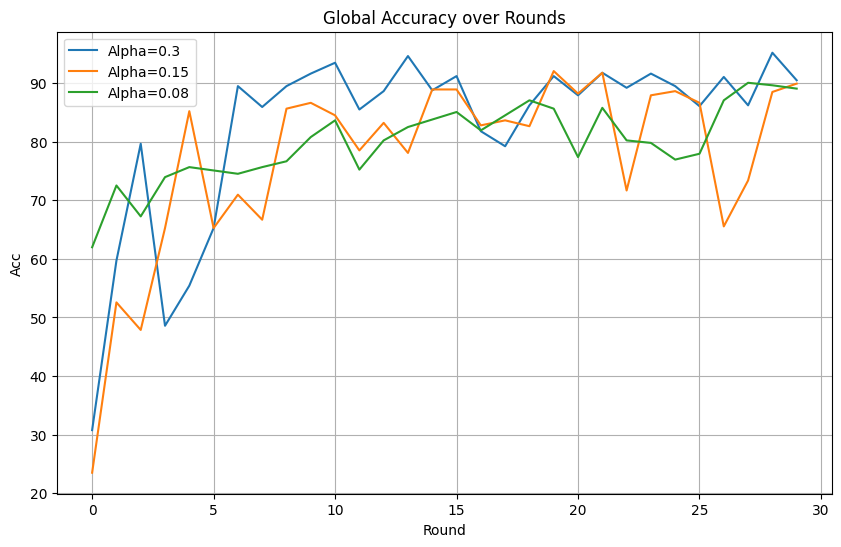

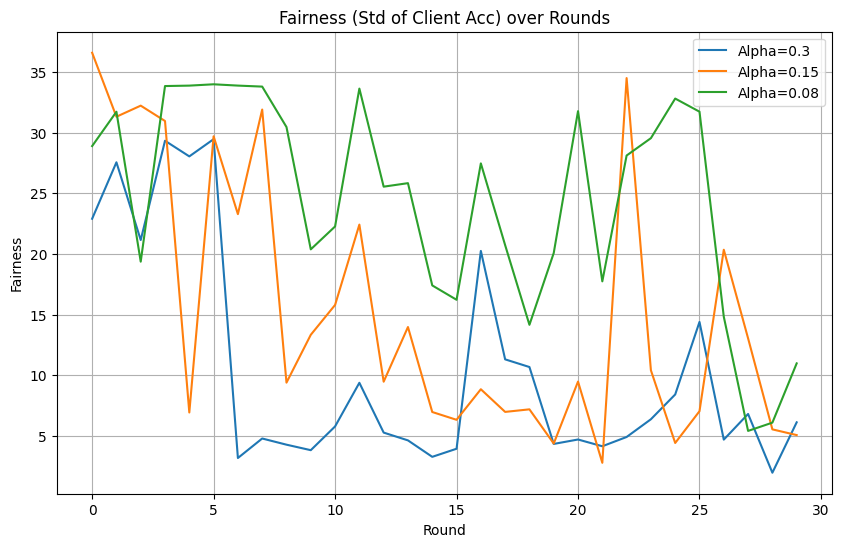

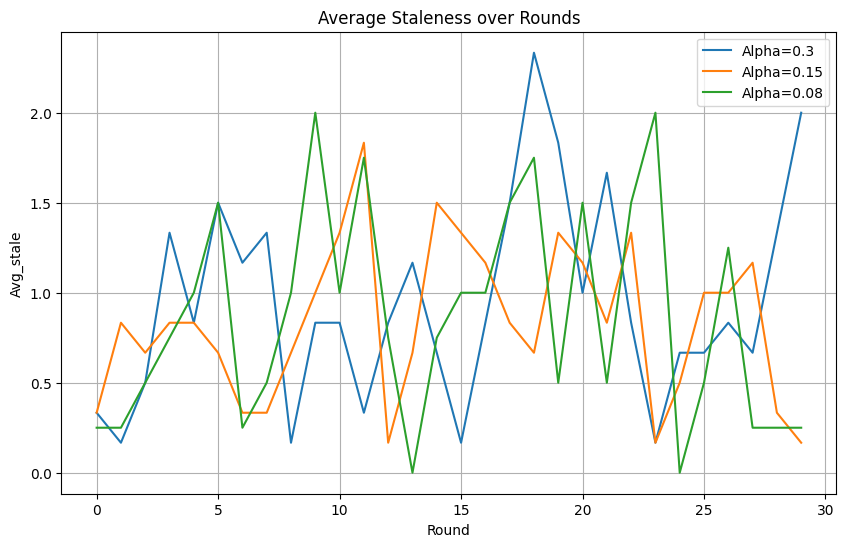

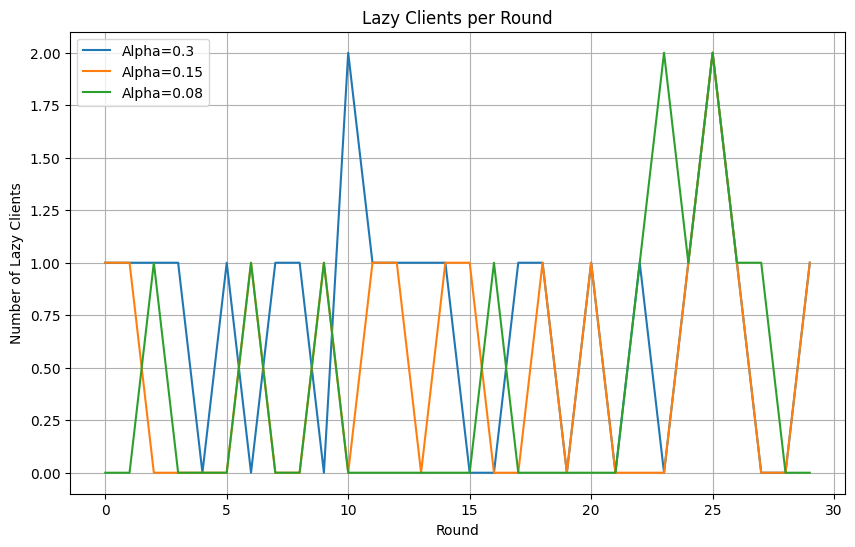

In [9]:
import matplotlib.pyplot as plt

# -----------------------------------------
# Plot function
# -----------------------------------------
def plot_fl_results(logs, metric='acc', title=None):
    plt.figure(figsize=(10,6))
    
    for alpha, log_data in logs.items():
        values = [round_stats[metric] for round_stats in log_data]
        plt.plot(range(len(values)), values, label=f'Alpha={alpha}')
    
    plt.xlabel('Round')
    plt.ylabel(metric.capitalize())
    if title:
        plt.title(title)
    else:
        plt.title(f'FL {metric.capitalize()} over Rounds')
    plt.grid(True)
    plt.legend()
    plt.show()

# -----------------------------------------
# Plot accuracy
# -----------------------------------------
plot_fl_results(all_alpha_logs, metric='acc', title='Global Accuracy over Rounds')

# -----------------------------------------
# Plot fairness (std of client accuracies)
# -----------------------------------------
plot_fl_results(all_alpha_logs, metric='fairness', title='Fairness (Std of Client Acc) over Rounds')

# -----------------------------------------
# Plot average staleness
# -----------------------------------------
plot_fl_results(all_alpha_logs, metric='avg_stale', title='Average Staleness over Rounds')

# -----------------------------------------
# Plot number of lazy clients
# -----------------------------------------
plt.figure(figsize=(10,6))
for alpha, log_data in all_alpha_logs.items():
    lazy_counts = [len(round_stats['lazy_clients']) for round_stats in log_data]
    plt.plot(range(len(lazy_counts)), lazy_counts, label=f'Alpha={alpha}')
plt.xlabel('Round')
plt.ylabel('Number of Lazy Clients')
plt.title('Lazy Clients per Round')
plt.grid(True)
plt.legend()
plt.show()

In [10]:
import copy
import random
import numpy as np
import torch
from torch.utils.data import DataLoader, Subset
import json

print("Running FINAL FL with QFedAvg + FedBuff + FedProx + Lazy + Availability + StoreForward + Defenses")

# ==========================================
# Hyperparameters
# ==========================================
ALPHA_LIST = [0.3, 0.15, 0.08]
LAZY_PROB = 0.15
MIN_ACTIVE = 3
FEDPROX_MU = 0.01
APPLY_PROB = 0.2
MAX_AGE = 3
TRIM_RATIO = 0.2
LOCAL_EPOCHS = 1
NUM_CLASSES = len(full_dataset.classes)
BATCH_SIZE = 32
ROUNDS = 30
Q_VAL = 0.2
LAZY_NORM_THRESHOLD = 0.02

all_alpha_logs = {}

# ==========================================
# Model update norm (for adaptive filtering)
# ==========================================
def model_update_norm(global_model, local_model):
    norm = 0.0
    g_state = global_model.state_dict()
    l_state = local_model.state_dict()
    for k in g_state:
        if not torch.is_floating_point(g_state[k]):
            continue
        diff = l_state[k] - g_state[k]
        norm += torch.norm(diff).item() ** 2
    return norm ** 0.5

# ==========================================
# Trimmed Mean aggregation
# ==========================================
def trimmed_mean_aggregate(global_model, client_models, trim_ratio=0.2):
    new_state = copy.deepcopy(global_model.state_dict())
    client_states = [m.state_dict() for m in client_models]
    n_clients = len(client_states)
    trim_k = int(n_clients * trim_ratio)

    for key in new_state:
        if not torch.is_floating_point(new_state[key]):
            continue
        stacked = torch.stack([cs[key].float() for cs in client_states], dim=0)
        sorted_vals, _ = torch.sort(stacked, dim=0)
        if n_clients > 2 * trim_k:
            trimmed = sorted_vals[trim_k:n_clients - trim_k]
        else:
            trimmed = sorted_vals
        new_state[key] = torch.mean(trimmed, dim=0)
    return new_state

# ==========================================
# QFedAvg weights computation
# ==========================================
def compute_q_weights(losses, samples, q=0.2):
    weights = [(s * ((l + 1e-10) ** q)) for l, s in zip(losses, samples)]
    total = sum(weights)
    return [w / total for w in weights]

# ==========================================
# QFedAvg aggregation
# ==========================================
def qfedavg_aggregate(global_model, client_models, weights):
    new_state = copy.deepcopy(global_model.state_dict())
    for key in new_state:
        if not torch.is_floating_point(new_state[key]):
            continue
        weighted_sum = sum(w * cm.state_dict()[key].float() for w, cm in zip(weights, client_models))
        new_state[key] = weighted_sum
    return new_state

# ==========================================
# Main loop over alphas
# ==========================================
for DIRICHLET_ALPHA in ALPHA_LIST:

    print("\n====================================")
    print("DIRICHLET_ALPHA =", DIRICHLET_ALPHA)
    print("====================================")

    # Create Dirichlet split
    client_map = create_dirichlet_split_from_indices(
        full_dataset,
        train_idx,
        NUM_CLIENTS,
        DIRICHLET_ALPHA,
        min_size=30
    )
    client_map = {cid: idxs for cid, idxs in client_map.items() if len(idxs) > 0}

    # Build client loaders
    client_loaders = {}
    for cid, idxs in client_map.items():
        idxs_sh = idxs.copy()
        np.random.shuffle(idxs_sh)
        n_local_train = max(1, int(0.85 * len(idxs_sh)))
        tr_idx = idxs_sh[:n_local_train]
        vl_idx = idxs_sh[n_local_train:]
        if len(vl_idx) == 0:
            vl_idx = tr_idx[:1]
        client_loaders[cid] = {
            "train": DataLoader(
                Subset(BrainTumorDataset(ROOT, transform=transform_train), tr_idx),
                batch_size=BATCH_SIZE,
                shuffle=True
            ),
            "val": DataLoader(
                Subset(BrainTumorDataset(ROOT, transform=transform_eval), vl_idx),
                batch_size=BATCH_SIZE,
                shuffle=False
            )
        }

    # Initialize buffers and staleness
    sf_buffer = {cid: [] for cid in client_loaders}
    staleness = {cid: 0 for cid in client_loaders}

    # Initialize model and FedBuff
    model = SimpleEffNet(num_classes=NUM_CLASSES).to(DEVICE)
    buffer = FedBuff()
    log_data = []

    # TRAINING LOOP
    for r in range(ROUNDS):

        active, delayed, lazy_clients = [], [], []

        # Dynamic availability selection
        availability = np.random.beta(DIRICHLET_ALPHA, DIRICHLET_ALPHA, len(client_loaders))
        for i, cid in enumerate(client_loaders):
            if random.random() < availability[i]:
                active.append(cid)
                staleness[cid] = 0
            else:
                delayed.append(cid)
                staleness[cid] += 1

        # Guarantee minimum active clients
        if len(active) < MIN_ACTIVE:
            pool = list(set(client_loaders.keys()) - set(active))
            needed = min(MIN_ACTIVE - len(active), len(pool))
            active += random.sample(pool, needed)
            delayed = [c for c in client_loaders if c not in active]

        client_models, client_losses, client_samples = [], [], []

        # ----------------------
        # ACTIVE CLIENTS TRAINING
        # ----------------------
        for cid in active:

            # Flush StoreForward buffer
            if len(sf_buffer[cid]) > 0:
                for upd in sf_buffer[cid]:
                    buffer.add(upd, len(client_loaders[cid]["train"].dataset), r)
                sf_buffer[cid] = []

            # Lazy client simulation
            if random.random() < LAZY_PROB:
                lazy_clients.append(cid)
                lm = SimpleEffNet(num_classes=NUM_CLASSES).to(DEVICE)
                lm.load_state_dict(model.state_dict())
                loss = 0.05
            else:
                lm, loss = local_train(
                    model,
                    client_loaders[cid]["train"],
                    LOCAL_EPOCHS,
                    use_fedprox=True,
                    mu=FEDPROX_MU
                )

            client_models.append(lm)
            client_losses.append(loss)
            client_samples.append(len(client_loaders[cid]["train"].dataset))

        # -----------------------------
        # Adaptive Norm Filtering
        # -----------------------------
        norms = [model_update_norm(model, lm) for lm in client_models]
        adaptive_threshold = np.mean(norms) - 0.5 * np.std(norms) if len(norms) > 1 else 0.0

        filtered_models = []
        filtered_losses = []
        filtered_samples = []
        detected_lazy = []

        for i, lm in enumerate(client_models):
            if norms[i] < adaptive_threshold:
                detected_lazy.append(active[i])
            else:
                filtered_models.append(lm)
                filtered_losses.append(client_losses[i])
                filtered_samples.append(client_samples[i])

        print("Detected lazy clients:", detected_lazy)

        # -----------------------------
        # QFedAvg + Trimmed Mean
        # -----------------------------
        if len(filtered_models) > 0:
            q_weights = compute_q_weights(filtered_losses, filtered_samples, q=Q_VAL)
            qfed_state = qfedavg_aggregate(model, filtered_models, q_weights)
            trimmed_state = trimmed_mean_aggregate(model, filtered_models, TRIM_RATIO)
            # You can choose either: combine or use trimmed_state
            model.load_state_dict(trimmed_state)

        # Apply FedBuff
        model.load_state_dict(buffer.apply(model.state_dict(), r, APPLY_PROB, MAX_AGE, 0.5))

        # ----------------------
        # Evaluation
        # ----------------------
        gacc, prec, rec, f1 = evaluate(model, central_val_loader)
        accs = [evaluate(model, client_loaders[c]["val"])[0] for c in client_loaders]
        fairness = float(np.std(accs))
        avg_stale = float(np.mean(list(staleness.values())))

        stats = {
            "round": r,
            "acc": gacc,
            "prec": prec,
            "rec": rec,
            "f1": f1,
            "fairness": fairness,
            "avg_stale": avg_stale,
            "active": active,
            "delayed": delayed,
            "lazy_clients": lazy_clients,
            "detected_lazy": detected_lazy,
            "losses": client_losses
        }

        print_summary(r, stats)
        log_data.append(stats)


    # --------------------------
    # Save final model and logs
    # --------------------------
    with open(f"/kaggle/working/logs/FINAL_FL_ALPHA_both{DIRICHLET_ALPHA}.json", "w") as f:
        json.dump(log_data, f, indent=2)

    torch.save(
        model.state_dict(),
        f"/kaggle/working/logs/FINAL_FL_ALPHA_both{DIRICHLET_ALPHA}_final.pth"
    )

    all_alpha_logs[DIRICHLET_ALPHA] = log_data

print("ALL FL EXPERIMENTS WITH FULL DEFENSES COMPLETED")

Running FINAL FL with QFedAvg + FedBuff + FedProx + Lazy + Availability + StoreForward + Defenses

DIRICHLET_ALPHA = 0.3
Detected lazy clients: [1]

================ ROUND 0 ================
Acc        : 63.82%
Precision  : 0.756
Recall     : 0.631
F1 Score   : 0.631
Fairness   : 15.303
Avg Stale  : 0.667
ClientLoss : [0.658, 0.721, 0.767]
Active     : [1, 4, 3]
Delayed    : [0, 2, 5]

Detected lazy clients: [2, 3]

================ ROUND 1 ================
Acc        : 37.89%
Precision  : 0.186
Recall     : 0.325
F1 Score   : 0.222
Fairness   : 29.167
Avg Stale  : 1.333
ClientLoss : [0.695, 0.813, 0.64]
Active     : [2, 5, 3]
Delayed    : [0, 1, 4]

Detected lazy clients: [5]

================ ROUND 2 ================
Acc        : 73.65%
Precision  : 0.848
Recall     : 0.702
F1 Score   : 0.688
Fairness   : 24.103
Avg Stale  : 1.167
ClientLoss : [1.137, 1.05, 0.315]
Active     : [0, 2, 5]
Delayed    : [1, 3, 4]

Detected lazy clients: [0, 3]

================ ROUND 3 ================
A

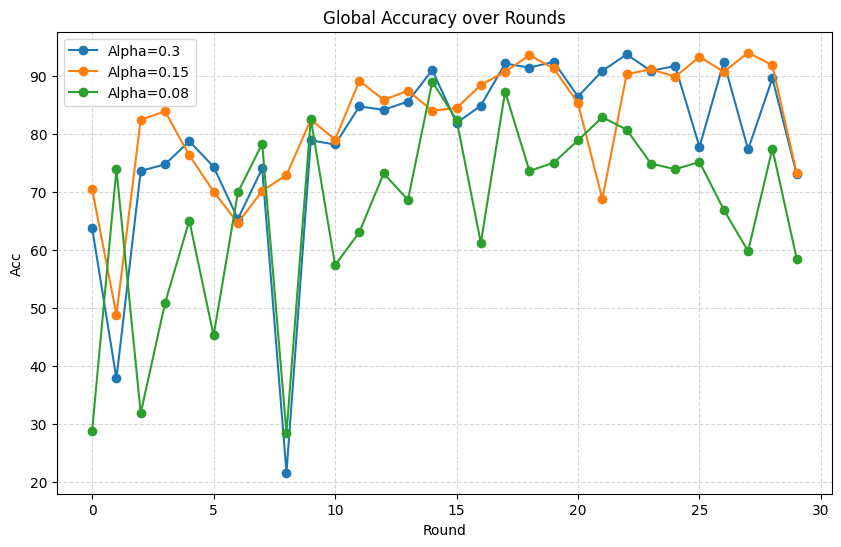

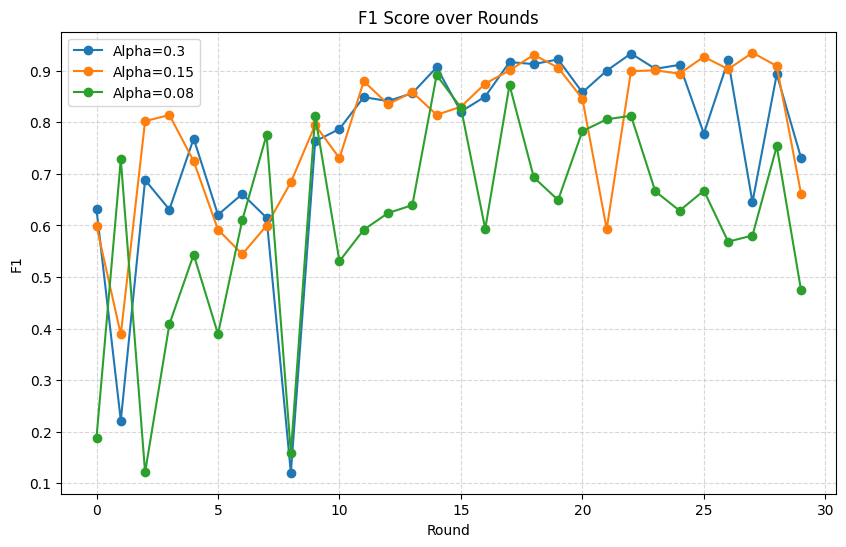

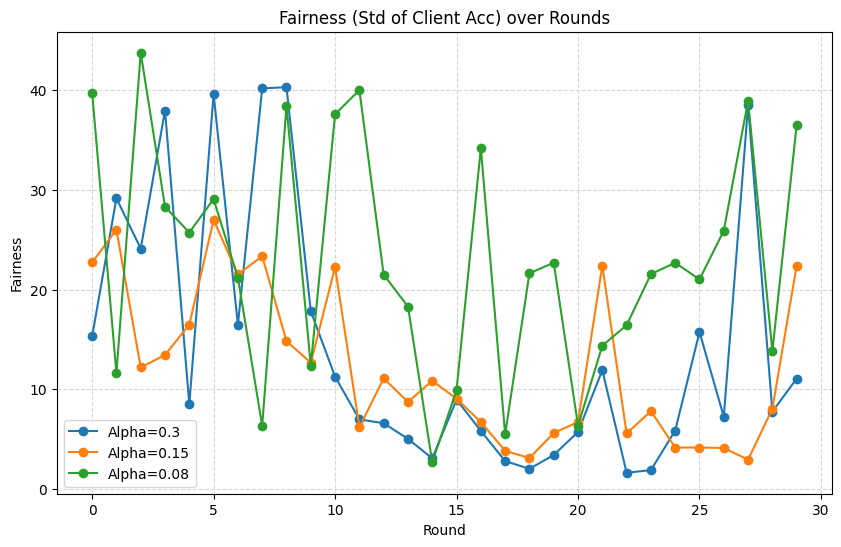

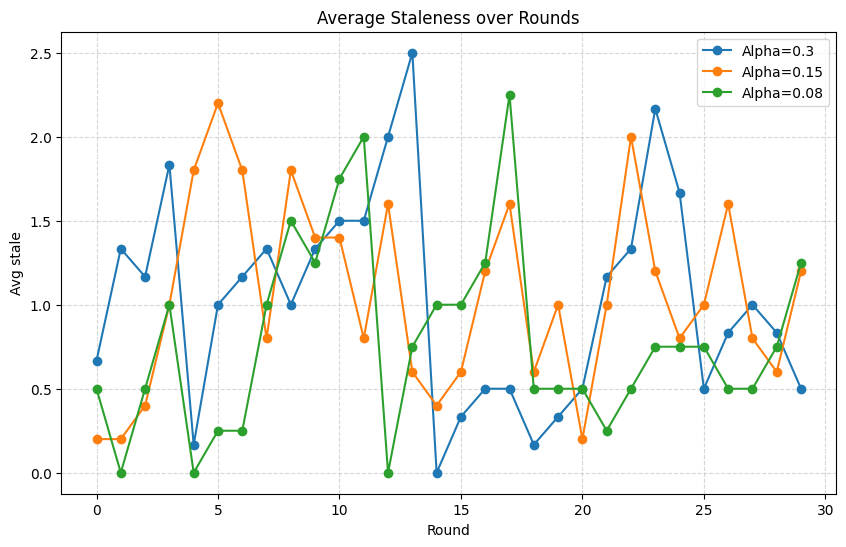

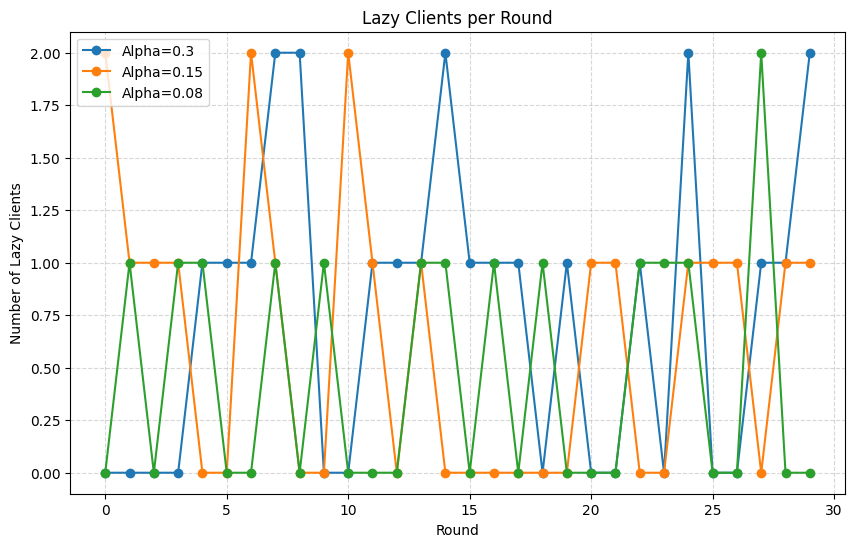

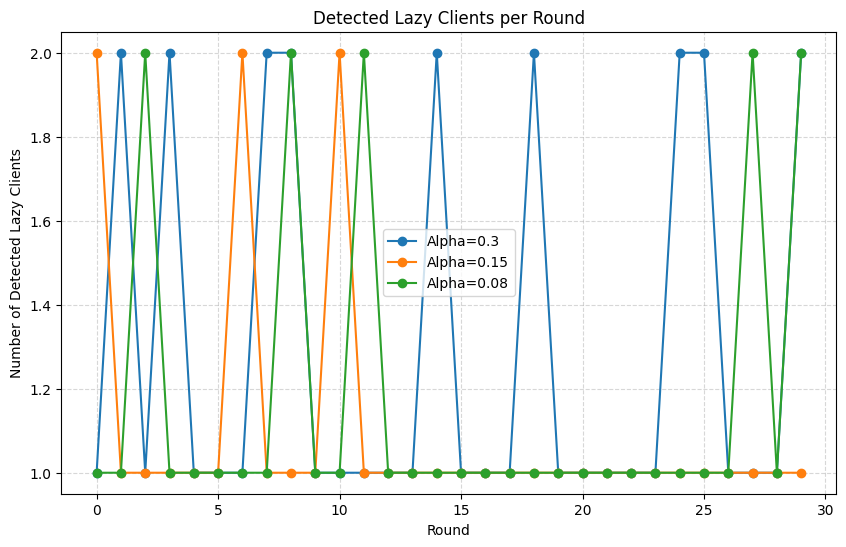

In [15]:
import matplotlib.pyplot as plt

# -----------------------------------------
# General plot function
# -----------------------------------------
def plot_fl_results(logs, metric='acc', title=None):
    plt.figure(figsize=(10,6))
    
    for alpha, log_data in logs.items():
        values = [round_stats[metric] for round_stats in log_data]
        plt.plot(range(len(values)), values, marker='o', label=f'Alpha={alpha}')
    
    plt.xlabel('Round')
    plt.ylabel(metric.replace('_', ' ').capitalize())
    if title:
        plt.title(title)
    else:
        plt.title(f'FL {metric.replace("_", " ").capitalize()} over Rounds')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.show()

# -----------------------------------------
# Plot Global Accuracy
# -----------------------------------------
plot_fl_results(all_alpha_logs, metric='acc', title='Global Accuracy over Rounds')

# -----------------------------------------
# Plot F1 Score
# -----------------------------------------
plot_fl_results(all_alpha_logs, metric='f1', title='F1 Score over Rounds')

# -----------------------------------------
# Plot Fairness (std of client accuracies)
# -----------------------------------------
plot_fl_results(all_alpha_logs, metric='fairness', title='Fairness (Std of Client Acc) over Rounds')

# -----------------------------------------
# Plot Average Staleness
# -----------------------------------------
plot_fl_results(all_alpha_logs, metric='avg_stale', title='Average Staleness over Rounds')

# -----------------------------------------
# Plot Number of Lazy Clients
# -----------------------------------------
plt.figure(figsize=(10,6))
for alpha, log_data in all_alpha_logs.items():
    lazy_counts = [len(round_stats['lazy_clients']) for round_stats in log_data]
    plt.plot(range(len(lazy_counts)), lazy_counts, marker='o', label=f'Alpha={alpha}')
plt.xlabel('Round')
plt.ylabel('Number of Lazy Clients')
plt.title('Lazy Clients per Round')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

# -----------------------------------------
# Plot Number of Detected Lazy Clients
# -----------------------------------------
plt.figure(figsize=(10,6))
for alpha, log_data in all_alpha_logs.items():
    detected_lazy_counts = [len(round_stats['detected_lazy']) for round_stats in log_data]
    plt.plot(range(len(detected_lazy_counts)), detected_lazy_counts, marker='o', label=f'Alpha={alpha}')
plt.xlabel('Round')
plt.ylabel('Number of Detected Lazy Clients')
plt.title('Detected Lazy Clients per Round')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()